In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker
from sagemaker.pytorch import PyTorch

from src import fetch_bucketed_from_bitmex, preprocess, train, evaluate

input_dir = 'cache_input'
model_dir = 'cache_model'
output_dir = 'cache_output'
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Crawling the Dataset

In [2]:
df = fetch_bucketed_from_bitmex('XBTZ19', '1m')

# Feature Engineering

In [4]:
preprocess(df, input_dir)

# Training

### Benchmark: Linear Model

In [15]:
train(
    input_dir=input_dir,
    output_dir=output_dir,
    model_dir=model_dir,
    checkpoint_path=None,
    # checkpoint_path='cache_output/checkpoint.pth',
    model_class="linear",
    seq_len= 128,
    hidden_dim= 128,
    n_epochs= 16,
    batch_size= 1024,
)

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 5.939e-02 | 4.119e-03 |      5 |
|     1 | 1.947e-03 | 3.025e-03 |      5 |
|     2 | 1.131e-03 | 2.059e-03 |      2 |
|     3 | 8.078e-04 | 1.709e-03 |      2 |
|     4 | 4.678e-04 | 1.009e-03 |      2 |
|     5 | 3.436e-04 | 9.348e-04 |      2 |
|     6 | 2.951e-04 | 8.908e-04 |      2 |
|     7 | 2.625e-04 | 8.570e-04 |      2 |
|     8 | 2.380e-04 | 8.430e-04 |      2 |
|     9 | 2.292e-04 | 8.357e-04 |      2 |
|    10 | 2.249e-04 | 8.297e-04 |      2 |
|    11 | 2.212e-04 | 8.244e-04 |      2 |
|    12 | 2.163e-04 | 8.204e-04 |      4 |
|    13 | 2.151e-04 | 8.195e-04 |      2 |
|    14 | 2.145e-04 | 8.190e-04 |      4 |
|    15 | 2.139e-04 | 8.185e-04 |      2 |


### Solution: LSTM Model

In [4]:
inputs = sagemaker_session.upload_data(
    path=input_dir, bucket=bucket, key_prefix="lstm-trader"
)

In [14]:
estimator = PyTorch(
    source_dir="src",
    entry_point="trainer.py",
    hyperparameters={
        "seq-len": 128,
        "hidden-dim": 128,
        "n-epochs": 16,
        "batch-size": 1024,
    },
    framework_version="1.2.0",
    role=role,
    sagemaker_session=sagemaker_session,
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
)

estimator.fit({"data_dir": inputs})

2020-01-02 07:17:43 Starting - Starting the training job...
2020-01-02 07:17:45 Starting - Launching requested ML instances......
2020-01-02 07:18:48 Starting - Preparing the instances for training......
2020-01-02 07:19:56 Downloading - Downloading input data......
2020-01-02 07:20:56 Training - Downloading the training image............
2020-01-02 07:22:59 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-02 07:23:00,771 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-02 07:23:00,797 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-02 07:23:00,798 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-02 07:23:01,109 sagemaker-containers INFO     Module trainer does not provide a setup.py. 
Generating setup.py
2020-01-02 07:23:0

In [11]:
sagemaker_session.download_data(
    path=model_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name + "/output/model.tar.gz",
)
!tar xvf cache_model/model.tar.gz --directory=cache_model

lstm.pth


# Evaluation

trai  linear  2.129500e-04
trai    lstm  1.002603e-04
vali  linear  8.184809e-04
vali    lstm  5.406404e-04
test  linear  6.136185e-04
test    lstm  2.981351e-02


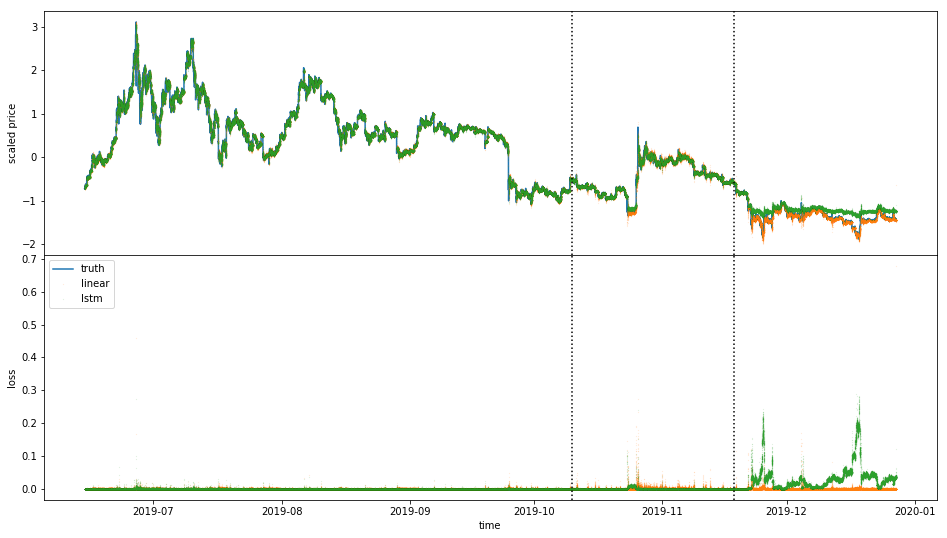

In [16]:
evaluate(input_dir, model_dir, seq_len=128)